### Importing Libraries

In [104]:
from encoder_model import EncoderDNN
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import accuracy_score
import torch as torch
import torch.nn as nn

import data_helper_413 as DataHelper
import model_413 as Model

os.environ["CUDA_VISIBLE_DEVICES"]='0'
from keras.backend.tensorflow_backend import set_session
config=tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.9
set_session(tf.Session(config=config))




# test_csv_path=os.path.join(base_dir,'/home/aries/413/CNNLoc-Access/TestData.csv')
# valid_csv_path=os.path.join(base_dir,'/home/aries/413/BSSID_CNNLOC/CNNLoc-Access/ValidationData.csv')
# train_csv_path=os.path.join(base_dir,'/home/aries/413/BSSID_CNNLOC/CNNLoc-Access/TrainingData.csv')

In [105]:
class NN(object):

    def __init__(self):
        self.normalize_valid_x= None
        self.normalize_x= None
        self.normalize_y= None
        self.normalize_valid_y= None

    def _preprocess(self, x, y, valid_x, valid_y, data_helper):
        #self.normY = data_helper_413.NormY()
        self.normalize_x = data_helper.normalizeX(x)
        self.normalize_valid_x = data_helper.normalizeX(valid_x)

        data_helper.normY.fit(y[:, 0], y[:, 1])
        self.longitude_normalize_y, self.latitude_normalize_y = data_helper.normY.normalizeY(y[:, 0], y[:, 1])
        self.floorID_y = y[:, 2]
        self.buildingID_y = y[:, 3]

        self.longitude_normalize_valid_y, self.latitude_normalize_valid_y = data_helper.normY.normalizeY(valid_y[:, 0],valid_y[:, 1])
        self.floorID_valid_y = valid_y[:, 2]
        self.buildingID_valid_y = valid_y[:, 3]

In [174]:
base_dir= os.getcwd()
test_csv_path=os.path.join(base_dir,'/home/aries/413/BSSID_CNNLOC/CNNLoc-Access/UTSIndoorLoc/UTS_test.csv')
valid_csv_path=os.path.join(base_dir,'/home/aries/413/BSSID_CNNLOC/CNNLoc-Access/UTSIndoorLoc/UTS_test.csv')
train_csv_path=os.path.join(base_dir,'/home/aries/413/BSSID_CNNLOC/CNNLoc-Access/UTSIndoorLoc/UTS_training.csv')

data_helper = DataHelper.DataHelper()
data_helper.set_config(wap_size=589,long=589,lat=590,floor=591,building_id=592) # UTSIndoorLoc
# data_helper.set_config(wap_size=301,long=301,lat=302,floor=303,building_id=304) # Self-collected
# data_helper.set_config(wap_size=520,long=520,lat=521,floor=522,building_id=523) # UJIIndoorLoc
(train_x, train_y), (valid_x, valid_y),(test_x,test_y) = data_helper.load_data_all(train_csv_path, valid_csv_path,test_csv_path)

# (train_x,train_y) = Model.filter_building(train_x,train_y,1)
# (valid_x, valid_y) = Model.filter_building(valid_x, valid_y,1)
nn_model = NN()
nn_model._preprocess(train_x,train_y,valid_x,valid_y,data_helper)

wap_size = train_x.shape[1]
print("Number of WAPs: " + str(wap_size))

Number of WAPs: 589


### Preprocessing
We preprocess the data, first by normalizing it, then we split it into a signal strength matrix and rank matrix, which is the input into the embedding. The rank matrix takes the indices of the WAPs and sorts them via the magnitude of the signal strength.

In [175]:
def preprocess_data(data, match_length=0):
    # Initialize lists to store the preprocessed indices and signal strengths
    preprocessed_indices = []
    preprocessed_strengths = []

    # Iterate over each sample in the batch
    for sample in data:
        # Find the indices and values of non-zero signal strengths
        non_zero_indices = np.nonzero(sample)[0]
        non_zero_values = sample[non_zero_indices]

        # Sort the indices by signal strength in descending order
        sorted_indices = non_zero_indices[np.argsort(-non_zero_values)]
        sorted_values = non_zero_values[np.argsort(-non_zero_values)]

        # Append the sorted indices and values to the preprocessed data
        preprocessed_indices.append(sorted_indices)
        preprocessed_strengths.append(sorted_values)

    # Determine the maximum number of non-zero values in a sample
    M = max(len(indices) for indices in preprocessed_indices)
    
    if match_length > 0:
        M = match_length

    # Pad each list of indices and signal strengths to have the same length
    for i in range(len(preprocessed_indices)):
        padding = M - len(preprocessed_indices[i])
        preprocessed_indices[i] = np.pad(preprocessed_indices[i], (0, padding), 'constant')
        preprocessed_strengths[i] = np.pad(preprocessed_strengths[i], (0, padding), 'constant')

    # Stack the preprocessed data to form the final output
    preprocessed_indices = np.stack(preprocessed_indices)
    preprocessed_strengths = np.stack(preprocessed_strengths)

    return preprocessed_indices, preprocessed_strengths

### Model
This model uses an embedding layer as the first layer

In [161]:
from torch.nn.init import kaiming_uniform_, xavier_uniform_, xavier_normal_

class LocalizationModel(nn.Module):
    def __init__(self, num_waps, embedding_dim, hidden_dim, output_dim):
        super(LocalizationModel, self).__init__()
        self.embedding = nn.Embedding(num_waps, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        xavier_normal_(self.embedding.weight.data)

    def forward(self, x, signal_strengths):
        # x is of shape (batch_size, M), where M is the maximum number of non-zero signal strengths in a sample
        # signal_strengths is of shape (batch_size, M), corresponding to the signal strengths of the WAPs in x

        # Embed the WAP indices
        x = self.embedding(x)  # shape: (batch_size, M, embedding_dim)

        # Multiply the embeddings by the signal strengths
        x = x * signal_strengths.unsqueeze(-1)  # shape: (batch_size, M, embedding_dim)

        # Sum across the signal strength dimension to get a single vector for each sample
        x = x.sum(dim=1)  # shape: (batch_size, embedding_dim)

        # Pass through the first fully connected layer
        x = self.fc1(x)  # shape: (batch_size, hidden_dim)

        # Apply a ReLU activation function
        x = nn.ReLU()(x)

        # Pass through the second fully connected layer to get the output
        out = self.fc2(x)  # shape: (batch_size, output_dim)

        return out

### Training
First we build the DataLoaders from the seperated input data as well as the target values. Then we run the training algorithm for the NN.

In [176]:
from torch.utils.data import TensorDataset, DataLoader

# Preprocess the data
pre_x, pre_strengths = preprocess_data(nn_model.normalize_x)
pre_valid_x, pre_valid_strengths = preprocess_data(nn_model.normalize_valid_x, match_length=pre_x.shape[1])
pre_y = nn_model.floorID_y
pre_valid_y = nn_model.floorID_valid_y

# Convert the preprocessed data to PyTorch tensors
pre_y = np.vstack(pre_y).astype(np.long)
pre_valid_y = np.vstack(pre_valid_y).astype(np.long)

# Offset floors to account for basements
offset = pre_y.min() 
pre_y -= offset
pre_valid_y -= offset
num_classes = pre_y.max() + 1

# Convert the datasets to PyTorch tensors
pre_x = torch.tensor(pre_x, dtype=torch.long)
pre_strengths = torch.tensor(pre_strengths, dtype=torch.float32)
pre_valid_x = torch.tensor(pre_valid_x, dtype=torch.long)
pre_valid_strengths = torch.tensor(pre_valid_strengths, dtype=torch.float32)
# pre_y = torch.tensor(pre_y, dtype=torch.long)
# pre_valid_y = torch.tensor(pre_valid_y, dtype=torch.long)
pre_y = torch.tensor(pre_y.T[0], dtype=torch.long)
pre_valid_y = torch.tensor(pre_valid_y.T[0], dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(pre_x, pre_strengths, pre_y)
valid_dataset = TensorDataset(pre_valid_x, pre_valid_strengths, pre_valid_y)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size)
print(pre_x.shape, pre_strengths.shape, pre_y.shape)

torch.Size([9108, 69]) torch.Size([9108, 69]) torch.Size([9108])


In [94]:
model = LocalizationModel(520, 50, 50, 5)

x = pre_x
signal_strengths = pre_strengths

# print(model.embedding.weight.data)

x = model.embedding(x)  # shape: (batch_size, M, embedding_dim)

print(x.shape)

# Multiply the embeddings by the signal strengths
x = x * signal_strengths.unsqueeze(-1)  # shape: (batch_size, M, embedding_dim)

print(x.shape)

# Sum across the signal strength dimension to get a single vector for each sample
x = x.sum(dim=1)  # shape: (batch_size, embedding_dim)

print(x.shape)

# Pass through the first fully connected layer
x = model.fc1(x)  # shape: (batch_size, hidden_dim)

# print(x.shape)

# Apply a ReLU activation function
x = nn.ReLU()(x)

# print(x[1])

# Pass through the second fully connected layer to get the output
out = model.fc2(x)  # shape: (batch_size, output_dim)

# print(out[1])

torch.Size([186, 272, 50])
torch.Size([186, 272, 50])
torch.Size([186, 50])


In [163]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt

# Define the device
device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
print(torch.cuda.get_arch_list())


def train_emb_model(model, num_epochs, learning_rate):

    # Define the loss function and optimizer
    criterion = CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize lists to store losses and accuracies
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        # Training
        train_loss, train_correct, total = 0, 0, 0
        model.train()
        for i, (inputs, signal_strengths, targets) in enumerate(train_loader):
            inputs, signal_strengths, targets = inputs.to(device), signal_strengths.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, signal_strengths)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accs.append(train_correct / total)

        # Validation
        val_loss, val_correct, total = 0, 0, 0
        model.eval()
        with torch.no_grad():
            for i, (inputs, signal_strengths, targets) in enumerate(val_loader):
                inputs, signal_strengths, targets = inputs.to(device), signal_strengths.to(device), targets.to(device)

                outputs = model(inputs, signal_strengths)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / total)

        print(f'Epoch: {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, train_losses, val_losses, train_accs, val_accs


['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37']


Epoch: 1, Train Loss: 2.4107, Train Acc: 0.2814, Val Loss: 2.3351, Val Acc: 0.2680
Epoch: 2, Train Loss: 1.3928, Train Acc: 0.5898, Val Loss: 1.4397, Val Acc: 0.5979
Epoch: 3, Train Loss: 0.6651, Train Acc: 0.8691, Val Loss: 0.6184, Val Acc: 0.8608
Epoch: 4, Train Loss: 0.3470, Train Acc: 0.9482, Val Loss: 0.4471, Val Acc: 0.9304
Epoch: 5, Train Loss: 0.2327, Train Acc: 0.9642, Val Loss: 0.3932, Val Acc: 0.9330
Epoch: 6, Train Loss: 0.1747, Train Acc: 0.9685, Val Loss: 0.3914, Val Acc: 0.9433
Epoch: 7, Train Loss: 0.1407, Train Acc: 0.9754, Val Loss: 0.4029, Val Acc: 0.9459
Epoch: 8, Train Loss: 0.1182, Train Acc: 0.9783, Val Loss: 0.4143, Val Acc: 0.9407
Epoch: 9, Train Loss: 0.1010, Train Acc: 0.9820, Val Loss: 0.4367, Val Acc: 0.9433
Epoch: 10, Train Loss: 0.0880, Train Acc: 0.9843, Val Loss: 0.4568, Val Acc: 0.9407
Epoch: 11, Train Loss: 0.0779, Train Acc: 0.9864, Val Loss: 0.4785, Val Acc: 0.9381
Epoch: 12, Train Loss: 0.0694, Train Acc: 0.9888, Val Loss: 0.4947, Val Acc: 0.9485
E

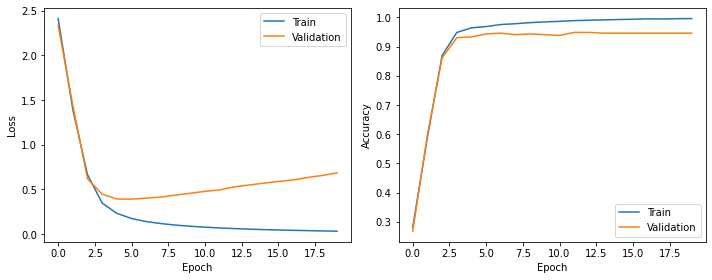

(LocalizationModel(
   (embedding): Embedding(589, 200)
   (fc1): Linear(in_features=200, out_features=200, bias=True)
   (fc2): Linear(in_features=200, out_features=16, bias=True)
 ),
 [2.410662179226642,
  1.3927855941799137,
  0.6651109054788843,
  0.3469671721641834,
  0.23270677019666125,
  0.17467337687844997,
  0.14067532976607341,
  0.11818638563781352,
  0.10104457030424496,
  0.08804316536712271,
  0.07794019685393863,
  0.06938811103728684,
  0.06216759792809094,
  0.05597581196628459,
  0.050819431541494084,
  0.04635069091556841,
  0.042515168667622755,
  0.039282852112986405,
  0.03594151523104263,
  0.03320930102413481],
 [2.335115364619664,
  1.439745545387268,
  0.6183962055615017,
  0.44713638510022846,
  0.3931931587202208,
  0.391364149749279,
  0.40285671821662355,
  0.4142706239862101,
  0.43667159468999933,
  0.45679152357791153,
  0.47849139996937345,
  0.49466715280764867,
  0.5284160392891083,
  0.5491783174553088,
  0.5699503207579255,
  0.5889122274571231,
 

In [177]:
# Create the model
embedding_dim = 200
hidden_dim = 200
# num_classes = 6

model = LocalizationModel(wap_size, embedding_dim, hidden_dim, num_classes).to(device)
train_emb_model(model, num_epochs=20, learning_rate=0.0005)

### Cosine Similarity
We can analyze the cosine similarity by displaying the top 5 WAPs with the highest cosine similarity.

In [179]:
from torch.nn.functional import cosine_similarity

def print_top_five_similar_waps(model):
    # Get the embeddings from the model
    embeddings = model.embedding.weight.data

    # Iterate over each WAP
    for i in range(embeddings.shape[0]):
        # Compute the cosine similarity with all other WAPs
        similarities = cosine_similarity(embeddings[i].unsqueeze(0), embeddings)

        # Get the indices of the top five most similar WAPs
        top_five_indices = similarities.topk(6)[1]

        # Remove the WAP itself from the list
        top_five_indices = top_five_indices[top_five_indices != i]

        # Print the WAP and its top five most similar WAPs
        print(f'WAP {i+1}:', ', '.join(f'WAP {j+1} (similarity: {similarities[j]:.4f})' for j in top_five_indices))

print_top_five_similar_waps(model)

WAP 1: WAP 3 (similarity: 0.9100), WAP 459 (similarity: 0.8970), WAP 78 (similarity: 0.8968), WAP 77 (similarity: 0.8883), WAP 2 (similarity: 0.8699)
WAP 2: WAP 3 (similarity: 0.8942), WAP 1 (similarity: 0.8699), WAP 319 (similarity: 0.8664), WAP 76 (similarity: 0.8410), WAP 78 (similarity: 0.8207)
WAP 3: WAP 1 (similarity: 0.9100), WAP 2 (similarity: 0.8942), WAP 78 (similarity: 0.8936), WAP 459 (similarity: 0.8791), WAP 77 (similarity: 0.8773)
WAP 4: WAP 160 (similarity: 0.9659), WAP 117 (similarity: 0.9644), WAP 162 (similarity: 0.9509), WAP 130 (similarity: 0.9493), WAP 161 (similarity: 0.9489)
WAP 5: WAP 339 (similarity: 0.9364), WAP 341 (similarity: 0.9309), WAP 241 (similarity: 0.9177), WAP 240 (similarity: 0.9132), WAP 340 (similarity: 0.9104)
WAP 6: WAP 355 (similarity: 0.9588), WAP 354 (similarity: 0.9588), WAP 131 (similarity: 0.9562), WAP 127 (similarity: 0.9520), WAP 464 (similarity: 0.9507)
WAP 7: WAP 465 (similarity: 0.9577), WAP 582 (similarity: 0.9550), WAP 583 (simila

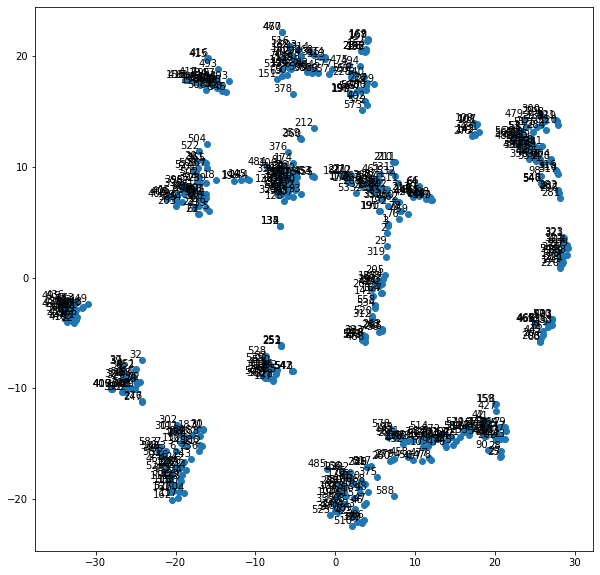

In [180]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(model):
    # Get the embeddings from the model
    embeddings = model.embedding.weight.data.cpu().numpy()

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot the embeddings
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    for i, coords in enumerate(embeddings_2d):
        plt.text(coords[0], coords[1], str(i+1), verticalalignment='bottom', horizontalalignment='right')
    plt.show()

visualize_embeddings(model)

### Fully Connected
We train another fully connected model for reference

Epoch: 1, Train Loss: 1.0015, Train Acc: 0.6521, Val Loss: 0.3316, Val Acc: 0.9298
Epoch: 2, Train Loss: 0.2366, Train Acc: 0.9476, Val Loss: 0.2335, Val Acc: 0.9199
Epoch: 3, Train Loss: 0.1557, Train Acc: 0.9602, Val Loss: 0.2279, Val Acc: 0.9199
Epoch: 4, Train Loss: 0.1240, Train Acc: 0.9661, Val Loss: 0.2188, Val Acc: 0.9334
Epoch: 5, Train Loss: 0.1047, Train Acc: 0.9717, Val Loss: 0.2710, Val Acc: 0.9145
Epoch: 6, Train Loss: 0.0914, Train Acc: 0.9744, Val Loss: 0.2565, Val Acc: 0.9253
Epoch: 7, Train Loss: 0.0816, Train Acc: 0.9773, Val Loss: 0.2552, Val Acc: 0.9343
Epoch: 8, Train Loss: 0.0754, Train Acc: 0.9777, Val Loss: 0.2633, Val Acc: 0.9325
Epoch: 9, Train Loss: 0.0690, Train Acc: 0.9792, Val Loss: 0.3077, Val Acc: 0.9271
Epoch: 10, Train Loss: 0.0648, Train Acc: 0.9803, Val Loss: 0.3509, Val Acc: 0.9181
Epoch: 11, Train Loss: 0.0609, Train Acc: 0.9816, Val Loss: 0.3594, Val Acc: 0.9199
Epoch: 12, Train Loss: 0.0579, Train Acc: 0.9818, Val Loss: 0.3769, Val Acc: 0.9172
E

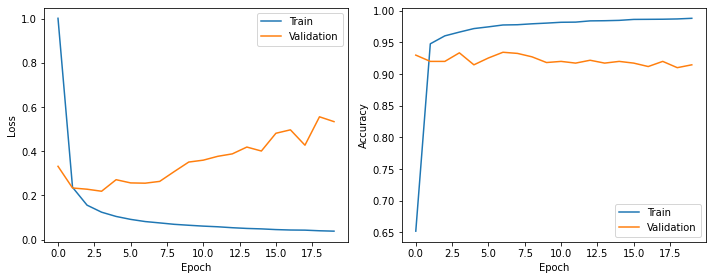

(FullyConnectedModel(
   (fc1): Linear(in_features=520, out_features=200, bias=True)
   (fc2): Linear(in_features=200, out_features=200, bias=True)
   (fc3): Linear(in_features=200, out_features=5, bias=True)
 ),
 [1.0015036883071446,
  0.2365818069770168,
  0.15574825110916907,
  0.1239572858485656,
  0.10468400007364555,
  0.09139385686079876,
  0.08156465695729145,
  0.07542172468488272,
  0.06904542158978681,
  0.06479320114102358,
  0.060883577877225786,
  0.057907589784381576,
  0.05365941975264249,
  0.050408426691063095,
  0.04837513445034766,
  0.045193047048180744,
  0.04328366527326393,
  0.042668800446195886,
  0.039846295161390655,
  0.03809087513348995],
 [0.3316182825300429,
  0.23351792411671746,
  0.22794687975611952,
  0.21876139090292984,
  0.271012370267676,
  0.2564707916850845,
  0.2552336943853233,
  0.2633294477644894,
  0.30769753989039195,
  0.35087647702958846,
  0.35941377339056796,
  0.3768598631593502,
  0.3879127177513308,
  0.41875875399758417,
  0.40081

In [167]:
# Define the device
device = torch.device('cpu')

class FullyConnectedModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FullyConnectedModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        out = self.fc3(x)
        return out
    
# Reshape the data
pre_x = nn_model.normalize_x
pre_valid_x = nn_model.normalize_valid_x

# Convert the datasets to PyTorch tensors
pre_x_flat = torch.tensor(pre_x, dtype=torch.float32)
pre_valid_x_flat = torch.tensor(pre_valid_x, dtype=torch.float32)

# Create TensorDatasets
train_dataset_flat = TensorDataset(pre_x_flat, pre_y)
valid_dataset_flat = TensorDataset(pre_valid_x_flat, pre_valid_y)

# Create DataLoaders
train_loader_flat = DataLoader(train_dataset_flat, batch_size=batch_size, shuffle=True)
val_loader_flat = DataLoader(valid_dataset_flat, batch_size=batch_size)

def train_model(model, num_epochs, learning_rate):
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize lists to store losses and accuracies
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        # Training
        train_loss, train_correct, total = 0, 0, 0
        model.train()
        for i, (inputs, targets) in enumerate(train_loader_flat):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_losses.append(train_loss / len(train_loader_flat))
        train_accs.append(train_correct / total)

        # Validation
        val_loss, val_correct, total = 0, 0, 0
        model.eval()
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(val_loader_flat):
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_losses.append(val_loss / len(val_loader_flat))
        val_accs.append(val_correct / total)

        print(f'Epoch: {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, train_losses, val_losses, train_accs, val_accs

model = FullyConnectedModel(wap_size, hidden_dim, num_classes).to(device)
train_model(model, num_epochs=20, learning_rate=0.0005)

### CBOWAP

In [35]:
def to_bow_waps(data, strengths, target, window_size=3):
    res = []
    for i in range(len(data) - window_size + 1):
        if data[i+window_size-1] == 0:
            break
        res.append([data[i:i+window_size], strengths[i:i+window_size], target])
    return res

# Preprocess the data
pre_x, pre_strengths = preprocess_data(nn_model.normalize_x)
pre_valid_x, pre_valid_strengths = preprocess_data(nn_model.normalize_valid_x)
pre_y = nn_model.floorID_y
pre_valid_y = nn_model.floorID_valid_y

# Convert the data to bag of WAPs format
bow_waps_data = [to_bow_waps(x, s, y) for x, s, y in zip(pre_x, pre_strengths, pre_y)]

# Flatten the data
bow_waps_data = [item for sublist in bow_waps_data for item in sublist]

# Separate the WAP indices, signal strengths, and targets
bow_waps_indices = [item[0] for item in bow_waps_data]
bow_waps_strengths = [item[1] for item in bow_waps_data]
bow_waps_targets = [item[2] for item in bow_waps_data]

# Convert the datasets to PyTorch tensors
bow_waps_indices = torch.tensor(bow_waps_indices, dtype=torch.long)
bow_waps_strengths = torch.tensor(bow_waps_strengths, dtype=torch.float32)
bow_waps_targets = torch.tensor(bow_waps_targets, dtype=torch.long)
pre_valid_x = torch.tensor(pre_valid_x, dtype=torch.long)
pre_valid_strengths = torch.tensor(pre_valid_strengths, dtype=torch.float32)
pre_valid_y = torch.tensor(pre_valid_y, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(bow_waps_indices, bow_waps_strengths, bow_waps_targets)
valid_dataset = TensorDataset(pre_valid_x, pre_valid_strengths, pre_valid_y)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size)

In [153]:
embedding_dim = 200
hidden_dim = 200

model = LocalizationModel(wap_size, embedding_dim, hidden_dim, num_classes).to(device)
train_emb_model(model, num_epochs=10, learning_rate=0.001)

IndexError: index out of range in self

### Convolutional Model

In [181]:
class CNNModel(nn.Module):
    def __init__(self, num_waps, embedding_dim, hidden_dim, output_dim):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(num_waps, embedding_dim)
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1)
        self.fc = nn.Linear(hidden_dim, output_dim)

        kaiming_uniform_(self.embedding.weight.data)

    def forward(self, x, signal_strengths):
        # x is of shape (batch_size, M), where M is the maximum number of non-zero signal strengths in a sample
        # signal_strengths is of shape (batch_size, M), corresponding to the signal strengths of the WAPs in x

        # Embed the WAP indices
        x = self.embedding(x)  # shape: (batch_size, M, embedding_dim)

        # Multiply the embeddings by the signal strengths
        x = x * signal_strengths.unsqueeze(-1)  # shape: (batch_size, M, embedding_dim)

        # Transpose the tensor to match the input shape requirement of nn.Conv1d
        x = x.transpose(1, 2)  # shape: (batch_size, embedding_dim, M)

        # Pass through the first convolutional layer
        x = self.conv1(x)  # shape: (batch_size, hidden_dim, M)

        # Apply a ReLU activation function
        x = nn.ReLU()(x)

        # Pass through the second convolutional layer
        x = self.conv2(x)  # shape: (batch_size, hidden_dim, M)

        # Apply a ReLU activation function
        x = nn.ReLU()(x)

        # Sum across the signal strength dimension to get a single vector for each sample
        x = x.sum(dim=2)  # shape: (batch_size, hidden_dim)

        # Pass through the fully connected layer to get the output
        out = self.fc(x)  # shape: (batch_size, output_dim)

        return out

Epoch: 1, Train Loss: 2.5244, Train Acc: 0.1944, Val Loss: 2.7197, Val Acc: 0.1392
Epoch: 2, Train Loss: 1.7174, Train Acc: 0.4413, Val Loss: 1.9236, Val Acc: 0.2861
Epoch: 3, Train Loss: 1.0931, Train Acc: 0.6511, Val Loss: 1.3603, Val Acc: 0.5851
Epoch: 4, Train Loss: 0.5940, Train Acc: 0.8412, Val Loss: 0.8041, Val Acc: 0.7629
Epoch: 5, Train Loss: 0.3495, Train Acc: 0.9153, Val Loss: 0.5721, Val Acc: 0.8840
Epoch: 6, Train Loss: 0.2371, Train Acc: 0.9421, Val Loss: 0.5696, Val Acc: 0.8866
Epoch: 7, Train Loss: 0.1838, Train Acc: 0.9576, Val Loss: 0.6055, Val Acc: 0.8892
Epoch: 8, Train Loss: 0.1499, Train Acc: 0.9620, Val Loss: 0.6208, Val Acc: 0.9253
Epoch: 9, Train Loss: 0.1216, Train Acc: 0.9710, Val Loss: 0.6228, Val Acc: 0.9278
Epoch: 10, Train Loss: 0.1140, Train Acc: 0.9706, Val Loss: 0.6779, Val Acc: 0.9356
Epoch: 11, Train Loss: 0.0937, Train Acc: 0.9784, Val Loss: 0.7427, Val Acc: 0.9175
Epoch: 12, Train Loss: 0.0941, Train Acc: 0.9746, Val Loss: 0.7337, Val Acc: 0.9330
E

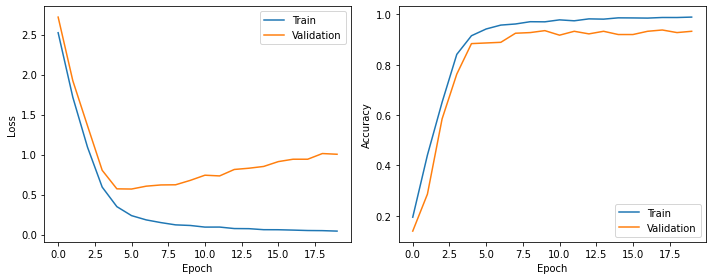

(CNNModel(
   (embedding): Embedding(589, 200)
   (conv1): Conv1d(200, 200, kernel_size=(1,), stride=(1,))
   (conv2): Conv1d(200, 200, kernel_size=(1,), stride=(1,))
   (fc): Linear(in_features=200, out_features=16, bias=True)
 ),
 [2.524415688081221,
  1.7173501136419655,
  1.0931048239027703,
  0.5939763798997119,
  0.3494665987424917,
  0.23713728780304635,
  0.18376707720694008,
  0.14990006376813342,
  0.12158428945324638,
  0.11404468031873653,
  0.0936537434418614,
  0.09409343295281271,
  0.07552405529479672,
  0.0740507873543701,
  0.06133959737404451,
  0.06071624844302456,
  0.05627554510492128,
  0.050967952127444684,
  0.04943304387298966,
  0.04368017498775014],
 [2.7196511200496127,
  1.923641358103071,
  1.3603188054902213,
  0.8040915642465863,
  0.5721344266619001,
  0.5696229764393398,
  0.6054709021534238,
  0.6208032092877797,
  0.6228391490876675,
  0.6779189338641507,
  0.7426793953137738,
  0.7336590066552162,
  0.8143218335296426,
  0.8299820523576013,
  0.852

In [182]:
embedding_dim = 200
hidden_dim = 200

model = CNNModel(wap_size, embedding_dim, hidden_dim, num_classes).to(device)
train_emb_model(model, num_epochs=20, learning_rate=0.0005)

Epoch: 1, Train Loss: 1.0015, Train Acc: 0.6521, Val Loss: 0.3316, Val Acc: 0.9298
Epoch: 2, Train Loss: 0.2366, Train Acc: 0.9476, Val Loss: 0.2335, Val Acc: 0.9199
Epoch: 3, Train Loss: 0.1557, Train Acc: 0.9602, Val Loss: 0.2279, Val Acc: 0.9199
Epoch: 4, Train Loss: 0.1240, Train Acc: 0.9661, Val Loss: 0.2188, Val Acc: 0.9334
Epoch: 5, Train Loss: 0.1047, Train Acc: 0.9717, Val Loss: 0.2710, Val Acc: 0.9145
Epoch: 6, Train Loss: 0.0914, Train Acc: 0.9744, Val Loss: 0.2565, Val Acc: 0.9253
Epoch: 7, Train Loss: 0.0816, Train Acc: 0.9773, Val Loss: 0.2552, Val Acc: 0.9343
Epoch: 8, Train Loss: 0.0754, Train Acc: 0.9777, Val Loss: 0.2633, Val Acc: 0.9325
Epoch: 9, Train Loss: 0.0690, Train Acc: 0.9792, Val Loss: 0.3077, Val Acc: 0.9271
Epoch: 10, Train Loss: 0.0648, Train Acc: 0.9803, Val Loss: 0.3509, Val Acc: 0.9181
Epoch: 11, Train Loss: 0.0609, Train Acc: 0.9816, Val Loss: 0.3594, Val Acc: 0.9199
Epoch: 12, Train Loss: 0.0579, Train Acc: 0.9818, Val Loss: 0.3769, Val Acc: 0.9172
E

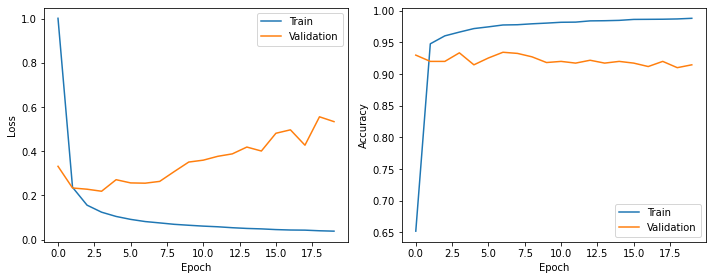

(FullyConnectedModel(
   (fc1): Linear(in_features=520, out_features=200, bias=True)
   (fc2): Linear(in_features=200, out_features=200, bias=True)
   (fc3): Linear(in_features=200, out_features=5, bias=True)
 ),
 [1.0015036883071446,
  0.2365818069770168,
  0.15574825110916907,
  0.1239572858485656,
  0.10468400007364555,
  0.09139385686079876,
  0.08156465695729145,
  0.07542172468488272,
  0.06904542158978681,
  0.06479320114102358,
  0.060883577877225786,
  0.057907589784381576,
  0.05365941975264249,
  0.050408426691063095,
  0.04837513445034766,
  0.045193047048180744,
  0.04328366527326393,
  0.042668800446195886,
  0.039846295161390655,
  0.03809087513348995],
 [0.3316182825300429,
  0.23351792411671746,
  0.22794687975611952,
  0.21876139090292984,
  0.271012370267676,
  0.2564707916850845,
  0.2552336943853233,
  0.2633294477644894,
  0.30769753989039195,
  0.35087647702958846,
  0.35941377339056796,
  0.3768598631593502,
  0.3879127177513308,
  0.41875875399758417,
  0.40081

In [ ]:
# Define the device
device = torch.device('cpu')

class FullyConnectedModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FullyConnectedModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        out = self.fc3(x)
        return out
    
# Reshape the data
pre_x = nn_model.normalize_x
pre_valid_x = nn_model.normalize_valid_x

# Convert the datasets to PyTorch tensors
pre_x_flat = torch.tensor(pre_x, dtype=torch.float32)
pre_valid_x_flat = torch.tensor(pre_valid_x, dtype=torch.float32)

# Create TensorDatasets
train_dataset_flat = TensorDataset(pre_x_flat, pre_y)
valid_dataset_flat = TensorDataset(pre_valid_x_flat, pre_valid_y)

# Create DataLoaders
train_loader_flat = DataLoader(train_dataset_flat, batch_size=batch_size, shuffle=True)
val_loader_flat = DataLoader(valid_dataset_flat, batch_size=batch_size)

def train_model(model, num_epochs, learning_rate):
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize lists to store losses and accuracies
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        # Training
        train_loss, train_correct, total = 0, 0, 0
        model.train()
        for i, (inputs, targets) in enumerate(train_loader_flat):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_losses.append(train_loss / len(train_loader_flat))
        train_accs.append(train_correct / total)

        # Validation
        val_loss, val_correct, total = 0, 0, 0
        model.eval()
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(val_loader_flat):
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_losses.append(val_loss / len(val_loader_flat))
        val_accs.append(val_correct / total)

        print(f'Epoch: {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, train_losses, val_losses, train_accs, val_accs

model = FullyConnectedModel(wap_size, hidden_dim, num_classes).to(device)
train_model(model, num_epochs=20, learning_rate=0.0005)

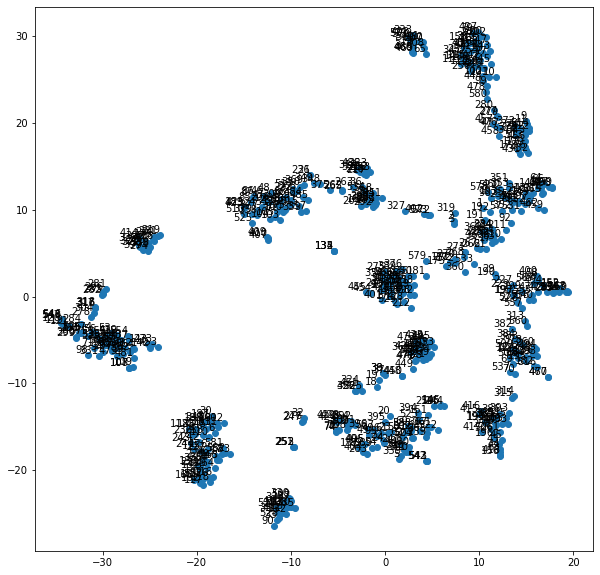

In [183]:
visualize_embeddings(model)

In [53]:
def count_parameters(num_waps, embedding_dim, hidden_dim, output_dim):
    # Parameters in the embedding layer
    embedding_params = num_waps * embedding_dim

    # Parameters in the first convolutional layer
    conv1_params = embedding_dim * hidden_dim

    # Parameters in the second convolutional layer
    conv2_params = hidden_dim * hidden_dim

    # Parameters in the fully connected layer
    fc_params = hidden_dim * output_dim

    # Total number of parameters
    total_params = embedding_params + conv1_params + conv2_params + fc_params

    return total_params

print(count_parameters(520, 200, 200, 5))

185000
